In [55]:
from google.colab import drive
drive.mount('/content/drive')
import io
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
archive_path = '/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data'

study_file=os.listdir('/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data')
print(study_file)
test_file = os.listdir('/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/test_data')
print(test_file)

['abortion_counts.csv', 'blm_movement_counts.csv', 'islam_counts.csv', 'espionage_counts.csv', 'human_rights_counts.csv', 'china_counts.csv', 'judaism_counts.csv', 'military_spending_counts.csv', 'guns_counts.csv', 'sexual_harrassment_counts.csv', 'oil_counts.csv', 'russia_counts.csv', 'native_americans_counts.csv', 'palestine_counts.csv', 'tech_censorship_counts.csv', 'universities_counts.csv']
['affirmative_action_counts.csv', 'israel_counts.csv', 'church_state_counts.csv', 'climate_change_counts.csv', 'cuba_counts.csv', 'prisons_counts.csv', 'public_finance_counts.csv', 'nuclear_weapons_counts.csv', 'police__counts.csv', 'private_finance_counts.csv', 'yemen_counts.csv', 'venezuela_counts.csv', 'us_immigration_counts.csv']


In [80]:
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data
for i in range(0, len(study_file)-1):
  globals()['study_data{}'.format(i)] = pd.read_csv(study_file[i], encoding='cp949', header=None)
  globals()['study_data{}'.format(i)] = globals()['study_data{}'.format(i)].drop(1, axis=1)

print(globals()['study_data{}'.format(0)].head)

%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/test_data
for i in range(0, len(test_file)-1):
  globals()['test_data{}'.format(i)] = pd.read_csv(test_file[i], encoding='cp949', header=None)
  globals()['test_data{}'.format(i)] = globals()['test_data{}'.format(i)].drop(1, axis=1)

/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data
<bound method NDFrame.head of                        0          2         3                     4   \
0                  PHRASE  aljazeera  alternet  americanconservative   
1                pro life         12        13                    68   
2         abortion rights         97        42                    15   
3           anti abortion         53        54                     4   
4             anti choice          0        54                     0   
5           abortion care          7        13                     0   
6               pregnancy         61        69                     8   
7                    kill          2         5                     1   
8        medical abortion          2         0                     0   
9         family planning         18        15                     0   
10           pro abortion          6         1                     3   
11                 murde

In [81]:
for i in range(0, len(study_file)-1):
  a = globals()['study_data{}'.format(i)][0]
  globals()['st_word{}'.format(i)] = a.values.tolist()
  del globals()['st_word{}'.format(i)][0]
#단어 리스트 
print(globals()['st_word{}'.format(0)])

#언론사 리스트
# media_list = globals()['study_data{}'.format(0)].iloc[0].tolist()
# del media_list[0]
for i in range(0, len(study_file)-1):
  globals()['media_list{}'.format(i)] = globals()['study_data{}'.format(i)].iloc[0].tolist()
  del globals()['media_list{}'.format(i)][0]
print(media_list0)
print(len(media_list0))
#리스트의 0 값은 PHRASE이므로 삭제해줌.

['pro life', 'abortion rights', 'anti abortion', 'anti choice', 'abortion care', 'pregnancy', 'kill', 'medical abortion', 'family planning', 'pro abortion', 'murder', 'fetus', 'mother', 'reproductive rights', 'infanticide', 'abortion access', 'abortion ban', 'infant', 'reproductive health', 'pro choice', 'abortion law', 'medication abortion', 'contraception', 'fetal heartbeat', 'fetal remains', 'abortion services', 'born alive', 'birth control', 'religious liberty', 'aborted', 'abortion rules', 'abortion providers', 'reproductive justice', 'womens rights', 'dead', 'termination', 'abortion clinic', 'adoption', 'rape or incest', 'maternal', 'abortion restrictions', 'abortion pills', 'unborn babies', 'abortionists', 'fetal abnormalities', 'human life', 'heartbeat bill', 'access to abortion', 'abortion industry', 'right to life']
['aljazeera', 'alternet', 'americanconservative', 'americanspectator', 'ap', 'atlantic', 'bbc', 'breitbart', 'buzzfeed', 'cbs', 'cnn', 'commondreams', 'conversati

In [82]:
#최대 단어 3개 뽑을때 사용할 csv 전처리(object 자료형 변환을 위해 삭제)
for i in range(0, len(study_file)-1):
  globals()['st_d{}'.format(i)]=globals()['study_data{}'.format(i)].drop(0).drop(0,axis=1)
  globals()['st_d{}'.format(i)]=globals()['st_d{}'.format(i)].apply(pd.to_numeric)
  # globals()['st_d{}'.format(i)]=globals()['st_d{}'.format(i)].to_numpy()
  globals()['st_d{}'.format(i)].columns = globals()['study_data{}'.format(i)].iloc[0,1:]
  globals()['st_d{}'.format(i)].reset_index(drop=True)
  globals()['st_d{}'.format(i)]=globals()['st_d{}'.format(i)].set_index(globals()['study_data{}'.format(i)].iloc[1:,0])
  # globals()['stu_d{}'.format(i)] = pd.DataFrame(globals()['st_d{}'.format(i)], columns=globals()['study_data{}'.format(i)].iloc[0,1:], index=globals()['study_data{}'.format(i)].iloc[1:,0])

# globals()['st_d0'][42]=globals()['st_d0'][43]
print(len(globals()['st_d{}'.format(0)]))
# print(len(globals()['st_d{}'.format(4)]))
globals()['st_d{}'.format(0)]


50


,aljazeera,alternet,americanconservative,americanspectator,ap,atlantic,bbc,breitbart,buzzfeed,cbs,...,rt,slate,spectator,townhall,truthdig,usatoday,vice,vox,wapo,wsj
0,,,,,,,,,,,,,,,,,,,,,
pro life,12,13,68,10,7,16,0,200,48,63,...,22,59,52,26,5,131,13,60,242,1
abortion rights,97,42,15,5,43,63,10,54,151,282,...,3,71,4,0,32,211,103,461,585,24
anti abortion,53,54,4,0,37,49,17,38,188,208,...,11,107,5,0,27,239,143,487,29,3
anti choice,0,54,0,0,0,1,0,8,4,7,...,1,10,0,1,5,5,38,14,19,0
abortion care,7,13,0,1,2,2,1,25,33,40,...,0,27,1,0,7,52,60,76,64,1
pregnancy,61,69,8,3,26,93,17,113,172,306,...,14,112,34,5,29,325,262,487,531,26
kill,2,5,1,1,0,3,0,13,3,2,...,17,8,19,1,1,21,6,29,14,0
medical abortion,2,0,0,0,1,0,4,4,21,2,...,0,2,0,0,0,3,2,8,9,0
family planning,18,15,0,1,43,10,3,50,42,66,...,0,8,3,0,27,39,12,72,130,9


In [60]:
def kth_largest_number(arr, K):
  unique_nums = list(arr)
  sorted_nums = sorted(unique_nums, reverse=True)
  return sorted_nums[K-1]

In [91]:
#가장 숫자 높은 단어 세개씩만 각 열마다...
for k in range(0, len(study_file)-1):
  globals()['word_3{}'.format(k)]=[]
  for i in range(0, len(globals()['media_list{}'.format(k)])-1):
    # data.append(kth_largest_number(globals()['st_d{}'.format(k)][i], 1))
    # print(kth_largest_number(globals()['st_d{}'.format(k)][i], 1))
    df = globals()['st_d{}'.format(k)]
    a = df.nlargest(3, globals()['media_list{}'.format(k)][i])
    A = a.index.to_list()
    # print(A)
    globals()['word_3{}'.format(k)].append(A)
    # data.append(df.sort_values(by=media_list[i-2], ascending=False).groupby(globals()['st_word{}'.format(i-2)]).head(3))
  # globals()['st_top{}'.format(k)] = pd.DataFrame(data, columns=['x','y','z'], index=globals()['media_list{}'.format(k)])

# print(globals()['st_top{}'.format(0)])
print(len(globals()['word_3{}'.format(0)]))

globals()['word_3{}'.format(0)]

45


[['abortion rights', 'pregnancy', 'anti abortion'],
 ['pregnancy', 'birth control', 'anti abortion'],
 ['pro life', 'abortion rights', 'mother'],
 ['pro life', 'dead', 'contraception'],
 ['abortion rights', 'family planning', 'anti abortion'],
 ['pregnancy', 'abortion rights', 'anti abortion'],
 ['anti abortion', 'pregnancy', 'fetus'],
 ['pro life', 'pregnancy', 'abortion rights'],
 ['anti abortion', 'pregnancy', 'abortion rights'],
 ['pregnancy', 'abortion rights', 'anti abortion'],
 ['pregnancy', 'abortion rights', 'anti abortion'],
 ['abortion care', 'pregnancy', 'anti choice'],
 ['pregnancy', 'medical abortion', 'reproductive health'],
 ['anti abortion', 'fetus', 'pregnancy'],
 ['pro life', 'pregnancy', 'mother'],
 ['pregnancy', 'anti abortion', 'abortion rights'],
 ['pregnancy', 'anti abortion', 'abortion rights'],
 ['pro life', 'pregnancy', 'aborted'],
 ['pregnancy', 'abortion rights', 'pro choice'],
 ['pro life', 'pregnancy', 'mother'],
 ['pro life', 'pregnancy', 'mother'],
 ['p

{'pro life': 0, 'abortion rights': 1, 'anti abortion': 2, 'anti choice': 3, 'abortion care': 4, 'pregnancy': 5, 'kill': 6, 'medical abortion': 7, 'family planning': 8, 'pro abortion': 9, 'murder': 10, 'fetus': 11, 'mother': 12, 'reproductive rights': 13, 'infanticide': 14, 'abortion access': 15, 'abortion ban': 16, 'infant': 17, 'reproductive health': 18, 'pro choice': 19, 'abortion law': 20, 'medication abortion': 21, 'contraception': 22, 'fetal heartbeat': 23, 'fetal remains': 24, 'abortion services': 25, 'born alive': 26, 'birth control': 27, 'religious liberty': 28, 'aborted': 29, 'abortion rules': 30, 'abortion providers': 31, 'reproductive justice': 32, 'womens rights': 33, 'dead': 34, 'termination': 35, 'abortion clinic': 36, 'adoption': 37, 'rape or incest': 38, 'maternal': 39, 'abortion restrictions': 40, 'abortion pills': 41, 'unborn babies': 42, 'abortionists': 43, 'fetal abnormalities': 44, 'human life': 45, 'heartbeat bill': 46, 'access to abortion': 47, 'abortion industry

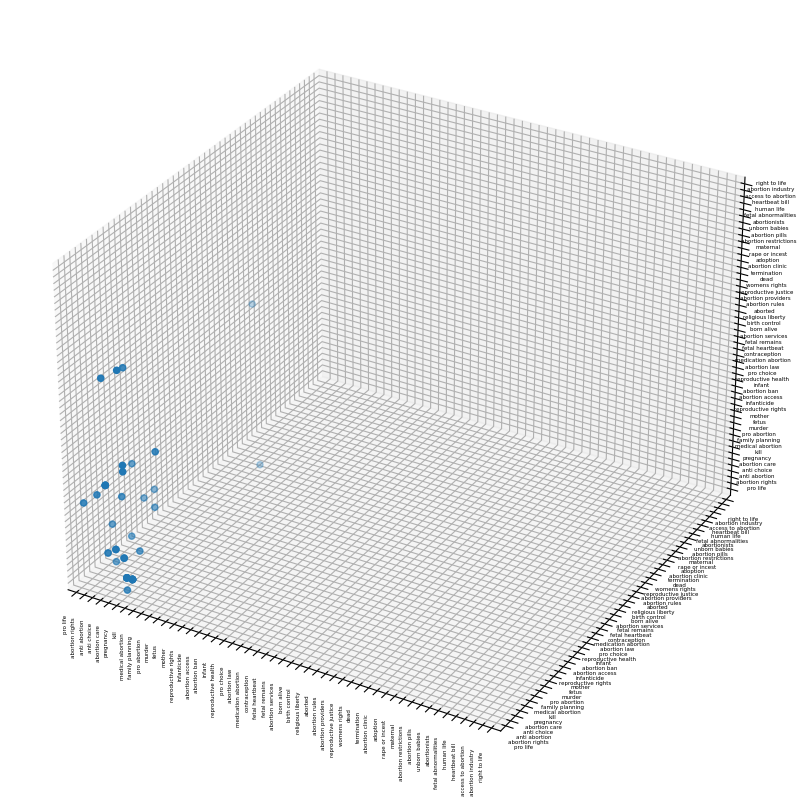

In [133]:
data = globals()['word_3{}'.format(0)]
mapping = {item: idx for idx, item in enumerate(globals()['st_word{}'.format(0)])}
print(mapping)

mapped_data = [[mapping[val] for val in lst] for lst in globals()['word_3{}'.format(0)]]

print(mapped_data)

data_int = []
for point in data:
    point_int = [mapping[label] for label in point]
    data_int.append(point_int)

# 축 레이블 리스트
axis_labels = list(mapping.keys())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 축 범위 지정
ax.set_xlim(0, len(mapping) - 1)
ax.set_ylim(0, len(mapping) - 1)
ax.set_zlim(0, len(mapping) - 1)


# 축 레이블 지정
ax.set_xticks(range(len(axis_labels)))
ax.set_yticks(range(len(axis_labels)))
ax.set_zticks(range(len(axis_labels)))
ax.set_xticklabels(axis_labels, fontsize=4, rotation=90)
ax.set_yticklabels(axis_labels, fontsize=4, rotation=0)
ax.set_zticklabels(axis_labels, fontsize=4, rotation=0)

# 데이터 플롯
x = [point[0] for point in data_int]
y = [point[1] for point in data_int]
z = [point[2] for point in data_int]
ax.scatter(x, y, z)


plt.show()
filename=f'/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/Untitled Folder/image_{i}.png'
plt.savefig(filename, dpi=300)